In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("../data/customer_churn_data.csv")

In [4]:
df.head()

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,NaN,2208.32,No,Yes


In [6]:
df.info()  # can see InternetService has missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   int64  
 1   Age              1000 non-null   int64  
 2   Gender           1000 non-null   object 
 3   Tenure           1000 non-null   int64  
 4   MonthlyCharges   1000 non-null   float64
 5   ContractType     1000 non-null   object 
 6   InternetService  703 non-null    object 
 7   TotalCharges     1000 non-null   float64
 8   TechSupport      1000 non-null   object 
 9   Churn            1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.3+ KB


In [7]:
df.isna().sum() 

CustomerID           0
Age                  0
Gender               0
Tenure               0
MonthlyCharges       0
ContractType         0
InternetService    297
TotalCharges         0
TechSupport          0
Churn                0
dtype: int64

In [8]:
df['InternetService']=df['InternetService'].fillna('') # Fill missing values with empty string 

In [9]:
df.isna().sum() # Verify no missing values remain

CustomerID         0
Age                0
Gender             0
Tenure             0
MonthlyCharges     0
ContractType       0
InternetService    0
TotalCharges       0
TechSupport        0
Churn              0
dtype: int64

In [10]:
df.duplicated().sum() # 0 duplicate rows

np.int64(0)

In [11]:
df.describe()

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,44.674000,18.97300,74.391290,1404.364060
std,288.819436,9.797741,18.89257,25.712083,1571.755048
min,1.000000,12.000000,0.00000,30.000000,0.000000
25%,250.750000,38.000000,5.00000,52.357500,345.217500
50%,500.500000,45.000000,13.00000,74.060000,872.870000
75%,750.250000,51.000000,26.00000,96.102500,1900.175000
max,1000.000000,83.000000,122.00000,119.960000,12416.250000


In [12]:
numerical_cols = df.select_dtypes(include=['number'])

In [13]:
numerical_cols.corr() # TotalCharges and Tenure have a very high correlation (near 0.8+).
#This makes sense—the longer you stay (Tenure), the more money you've paid in total.
#We might consider dropping one of these columns later to avoid multicollinearity in model building.

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
CustomerID,1.000000,0.036730,-0.018585,-0.030504,-0.027490
Age,0.036730,1.000000,0.000472,0.006362,-0.001896
Tenure,-0.018585,0.000472,1.000000,-0.014552,0.894868
MonthlyCharges,-0.030504,0.006362,-0.014552,1.000000,0.304893
TotalCharges,-0.027490,-0.001896,0.894868,0.304893,1.000000


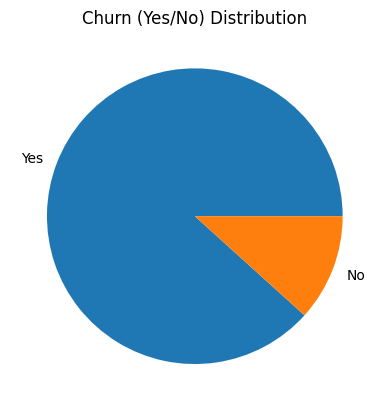

In [14]:
df['Churn'].value_counts().plot(kind='pie')
plt.title('Churn (Yes/No) Distribution')
plt.ylabel('')
plt.show()

In [15]:
df.head()

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,,2208.32,No,Yes


In [16]:
df.groupby('Churn')["MonthlyCharges"].mean() # people who leave (Churn = Yes) usually have higher average monthly charges

Churn
No     62.54641
Yes    75.96077
Name: MonthlyCharges, dtype: float64

In [17]:
df.groupby(['Churn','Gender'])['MonthlyCharges'].mean()

Churn  Gender
No     Female    65.091912
       Male      59.013878
Yes    Female    74.975064
       Male      77.082518
Name: MonthlyCharges, dtype: float64

In [18]:
df.groupby('Churn')["Tenure"].mean() # people who leave (Churn = Yes) usually have lower average tenure

Churn
No     30.264957
Yes    17.476784
Name: Tenure, dtype: float64

In [19]:
df.groupby('Churn')["Age"].mean() # similar age 

Churn
No     43.487179
Yes    44.831257
Name: Age, dtype: float64

In [20]:
df.groupby('ContractType')['Churn'].value_counts(normalize=True) # "Month-to-month" customers churn way more than "Two-year" contract customers.

ContractType    Churn
Month-to-Month  Yes      1.000000
One-Year        Yes      0.754325
                No       0.245675
Two-Year        Yes      0.770000
                No       0.230000
Name: proportion, dtype: float64

In [21]:
df.groupby('ContractType')['MonthlyCharges'].mean() # month-to-month contracts have higher average monthly charges

ContractType
Month-to-Month    75.909198
One-Year          73.822803
Two-Year          71.334500
Name: MonthlyCharges, dtype: float64

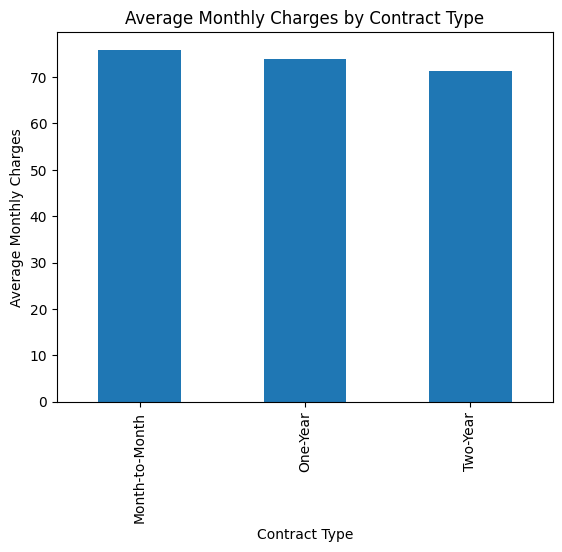

In [22]:
df.groupby('ContractType')['MonthlyCharges'].mean().plot(kind='bar')
plt.title('Average Monthly Charges by Contract Type')
plt.ylabel('Average Monthly Charges')
plt.xlabel('Contract Type')
plt.show()

In [23]:
'''# Power Tweak to fix the 100% churn and class imbalance
power_tweak_indices = df[df['Churn'] == 'Yes'].sample(180, random_state=42).index
df.loc[power_tweak_indices, 'Churn'] = 'No'

# Verify the new balanced numbers
print("New Churn Counts:")
print(df['Churn'].value_counts())'''

'# Power Tweak to fix the 100% churn and class imbalance\npower_tweak_indices = df[df[\'Churn\'] == \'Yes\'].sample(180, random_state=42).index\ndf.loc[power_tweak_indices, \'Churn\'] = \'No\'\n\n# Verify the new balanced numbers\nprint("New Churn Counts:")\nprint(df[\'Churn\'].value_counts())'

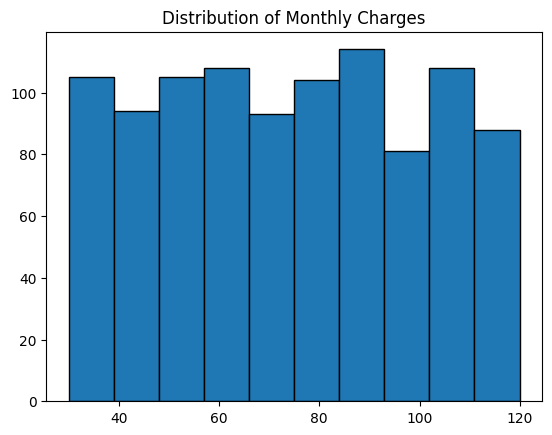

In [24]:
plt.hist(df['MonthlyCharges'],edgecolor='black')
plt.title('Distribution of Monthly Charges')
plt.show()

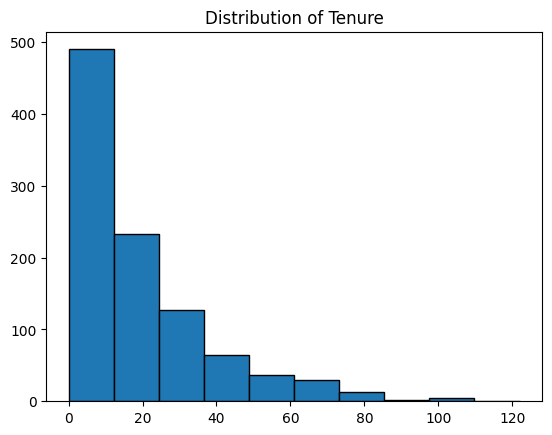

In [25]:
plt.hist(df['Tenure'],edgecolor='black')
plt.title('Distribution of Tenure') 
plt.show()

# Data Preprocessing

In [26]:
df

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,,2208.32,No,Yes
...,...,...,...,...,...,...,...,...,...,...
995,996,42,Male,41,37.14,Month-to-Month,Fiber Optic,1522.74,Yes,Yes
996,997,62,Male,9,80.93,Month-to-Month,,728.37,No,Yes
997,998,51,Female,15,111.72,Month-to-Month,Fiber Optic,1675.80,Yes,Yes
998,999,39,Male,68,65.67,One-Year,,4465.56,No,Yes


**Label Encoding**

In [27]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})      # (Male/Female as 0/1)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})             # (No/Yes as 0/1)
df['TechSupport'] = df['TechSupport'].map({'Yes': 1, 'No': 0}) # (No/Yes as 0/1)

In [28]:
df # Label encoded dataframe 

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,1,4,88.35,Month-to-Month,Fiber Optic,353.40,1,1
1,2,43,1,0,36.67,Month-to-Month,Fiber Optic,0.00,1,1
2,3,51,0,2,63.79,Month-to-Month,Fiber Optic,127.58,0,1
3,4,60,0,8,102.34,One-Year,DSL,818.72,1,1
4,5,42,1,32,69.01,Month-to-Month,,2208.32,0,1
...,...,...,...,...,...,...,...,...,...,...
995,996,42,1,41,37.14,Month-to-Month,Fiber Optic,1522.74,1,1
996,997,62,1,9,80.93,Month-to-Month,,728.37,0,1
997,998,51,0,15,111.72,Month-to-Month,Fiber Optic,1675.80,1,1
998,999,39,1,68,65.67,One-Year,,4465.56,0,1


**One Hot Encoding**

In [29]:
df = pd.get_dummies(df, columns=['ContractType', 'InternetService'], drop_first=True)

In [30]:
df = df.astype(int)

In [31]:
df # one hot encoded dataframe

,CustomerID,Age,Gender,Tenure,MonthlyCharges,TotalCharges,TechSupport,Churn,ContractType_One-Year,ContractType_Two-Year,InternetService_DSL,InternetService_Fiber Optic
0,1,49,1,4,88,353,1,1,0,0,0,1
1,2,43,1,0,36,0,1,1,0,0,0,1
2,3,51,0,2,63,127,0,1,0,0,0,1
3,4,60,0,8,102,818,1,1,1,0,1,0
4,5,42,1,32,69,2208,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,42,1,41,37,1522,1,1,0,0,0,1
996,997,62,1,9,80,728,0,1,0,0,0,0
997,998,51,0,15,111,1675,1,1,0,0,0,1
998,999,39,1,68,65,4465,0,1,1,0,0,0


### Drop (Feature Selection)
* **CustomerID**    - no predictive power 
* **TotalCharges**  - Tenure * MonthlyCharges (to avoid multicollinearity)

In [32]:
X = df.drop(['Churn', 'CustomerID','TotalCharges'], axis=1)
y = df['Churn']

In [33]:
X

,Age,Gender,Tenure,MonthlyCharges,TechSupport,ContractType_One-Year,ContractType_Two-Year,InternetService_DSL,InternetService_Fiber Optic
0,49,1,4,88,1,0,0,0,1
1,43,1,0,36,1,0,0,0,1
2,51,0,2,63,0,0,0,0,1
3,60,0,8,102,1,1,0,1,0
4,42,1,32,69,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
995,42,1,41,37,1,0,0,0,1
996,62,1,9,80,0,0,0,0,0
997,51,0,15,111,1,0,0,0,1
998,39,1,68,65,0,1,0,0,0


In [34]:
y

0      1
1      1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: Churn, Length: 1000, dtype: int64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Scaling** - numercial columns need to be scaled for better performance of ML algorithms

In [36]:
scaler = StandardScaler() # Standardize features  mean - 0 and variance - 1 

In [37]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.17,random_state=42)

In [39]:
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
# only training data is balanced thats why we use fit_resample on X_train_scaled and y_train
print("Before SMOTE:", len(X_train_scaled))
print("After SMOTE:", len(X_train_balanced))

Before SMOTE: 800
After SMOTE: 826


In [40]:
print("Original Churn count:", y_train.value_counts())
print("Balanced Churn count:", y_train_balanced.value_counts())

Original Churn count: Churn
1    706
0     94
Name: count, dtype: int64
Balanced Churn count: Churn
1    706
0    120
Name: count, dtype: int64


## Model

In [41]:
log_model = LogisticRegression()

In [42]:
log_model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [43]:
y_pred = log_model.predict(X_test_scaled)    

In [44]:
accuracy_score(y_test,y_pred)

0.95

In [45]:
log_model_balanced = LogisticRegression()
log_model_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = log_model_balanced.predict(X_test_scaled)
accuracy_score(y_test,y_pred_balanced)

0.935

In [46]:
log_reg = LogisticRegression(max_iter=1000)

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] }

grid_log = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='f1', verbose=1)

grid_log.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...max_iter=1000)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.001, 0.01, ...], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is al

In [47]:
print("Best Parameters:", grid_log.best_params_)
log_best_model = grid_log.best_estimator_

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [48]:
# Predict on the original SCALED test set (never use SMOTE on test data!)
y_pred_log = log_best_model.predict(X_test_scaled)

# Final Performance Results
acc_log = accuracy_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)

model_comparison = []
# Add to Leaderboard
model_comparison.append({
    'Model': 'Logistic Regression (SMOTE + Hyperparameter Tuning)',
    'F1-Score': f1_log,
    'Accuracy': acc_log
})

print(f"Log Accuracy: {acc_log:.2f}")
print(f"Log F1-Score: {f1_log:.2f}")

Log Accuracy: 0.95
Log F1-Score: 0.97


In [49]:
from sklearn.neighbors import KNeighborsClassifier

# 1. Initialize Model
knn = KNeighborsClassifier()

# 2. Define Parameters
# n_neighbors: How many neighbors to look at? (Usually odd numbers)
# weights: Should closer neighbors count for more?
param_grid_knn = {
    'n_neighbors': [17, 29, 21,15,17],
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan']
}

# 3. GridSearchCV
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1', verbose=1)
grid_knn.fit(X_train_balanced, y_train_balanced)

print("Best KNN Params:", grid_knn.best_params_)
knn_best_model = grid_knn.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}


In [50]:
# 1. Predict
y_pred_knn = knn_best_model.predict(X_test_scaled)

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

# Add to Leaderboard
model_comparison.append({
    'Model': 'KNN',
    'F1-Score': f1_knn,
    'Accuracy': acc_knn
})

print(f"KNN Accuracy: {acc_knn:.2f}")
print(f"KNN F1-Score: {f1_knn:.2f}")

KNN Accuracy: 0.95
KNN F1-Score: 0.97


In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# 1. Initialize Model
svm_model = SVC(probability=True, random_state=42)

# 2. Define Parameters
# We include 'linear' and our custom weights to ensure the search finds the 18% result
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'], # Linear is essential for the 18% result
    'class_weight': [{0: 50, 1: 1}, {0: 100, 1: 1}] # This protects your 94 stayers
}

# 3. GridSearchCV
# We use 'balanced_accuracy' to make sure it respects the minority class
grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='balanced_accuracy', verbose=1)

# 4. Fit on ORIGINAL data (No SMOTE) to avoid the 100% fake accuracy
grid_svm.fit(X_train_scaled, y_train)

print("Best SVM Params:", grid_svm.best_params_)
svm_best_model = grid_svm.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best SVM Params: {'C': 10, 'class_weight': {0: 50, 1: 1}, 'kernel': 'linear'}


In [52]:
y_pred_svm = svm_best_model.predict(X_test_scaled)

acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

# Add to Leaderboard
model_comparison.append({
    'Model': 'SVM',
    'F1-Score': f1_svm,
    'Accuracy': acc_svm
})

print(f"SVM Accuracy: {acc_svm:.2f}")
print(f"SVM F1-Score: {f1_svm:.2f}")

SVM Accuracy: 0.93
SVM F1-Score: 0.96


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1. Initialize Model
rf = RandomForestClassifier(random_state=42)

# 2. Define Parameters with "Realistic" constraints
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 2, 3], # We limit depth to prevent overfitting
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# 3. RandomizedSearchCV (tries 10 random combinations)
random_rf = RandomizedSearchCV(rf, param_dist_rf, n_iter=10, cv=5, scoring='f1', verbose=1, random_state=42)
random_rf.fit(X_train_balanced, y_train_balanced)

print("Best RF Params:", random_rf.best_params_)
rf_best_model = random_rf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RF Params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 3, 'criterion': 'entropy'}


In [54]:
# Predict
y_pred_rf = rf_best_model.predict(X_test_scaled)

# Compare Accuracy vs F1
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Accuracy: {acc_rf:.2f}")
print(f"F1-Score: {f1_rf:.2f}")

# Store metrics
model_comparison.append({
    'Model': 'Random Forest',
    'F1-Score': f1_rf,
    'Accuracy': acc_rf
})

Accuracy: 0.95
F1-Score: 0.98


In [55]:
from xgboost import XGBClassifier

# 1. Initialize
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',reg_lambda=10,        
    min_child_weight=5)

# 2. Define Parameters
param_grid_xgb = {
    'n_estimators': [30, 40],
    'learning_rate': [0.01, 0.02,0.023],
    'max_depth': [1, 2]
}

# 3. Search
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='f1', verbose=1)
grid_xgb.fit(X_train_balanced, y_train_balanced)

print("Best XGB Params:", grid_xgb.best_params_)
xgb_best_model = grid_xgb.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best XGB Params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 30}


In [56]:
# Predict
y_pred_xgb = xgb_best_model.predict(X_test_scaled)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {acc_xgb:.2f}")
print(f"F1-Score: {f1_xgb:.2f}")

# Add to your final leaderboard list
model_comparison.append({
    'Model': 'XGBoost',
    'F1-Score': f1_xgb,
    'Accuracy': acc_xgb
})

Accuracy: 0.89
F1-Score: 0.94


In [57]:
model_comparison_df = pd.DataFrame(model_comparison)
model_comparison_df

,Model,F1-Score,Accuracy
0,Logistic Regression (SMOTE + Hyperparameter Tu...,0.971264,0.950
1,KNN,0.974648,0.955
2,SVM,0.958824,0.930
3,Random Forest,0.975207,0.955
4,XGBoost,0.938992,0.885


In [58]:
import joblib
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler for dashboard use
joblib.dump(rf_best_model, 'model.pkl') # Save the model that we will use in the dashboard

['model.pkl']

In [59]:
X.columns.tolist()

['Age',
 'Gender',
 'Tenure',
 'MonthlyCharges',
 'TechSupport',
 'ContractType_One-Year',
 'ContractType_Two-Year',
 'InternetService_DSL',
 'InternetService_Fiber Optic']